In [4]:
import os

import numpy as np
import tensorflow as tf
from keras.src.api_export import keras_export
import keras
from keras import layers

import matplotlib.pyplot as plt
from tensorflow.python.ops.gen_data_flow_ops import tensor_array_gather_eager_fallback

num_deleted = 0

for folder in ('Drones', 'Brids'):
    folder_name = os.path.join('dataset/train', folder)

    for fname in os.listdir(folder_name):
        try:
            fobj = open(os.path.join(folder_name, fname), 'rb')
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_deleted += 1
            os.remove(folder_name + '/' + fname)

print(f"Deleted {num_deleted} files")


Deleted 0 files


In [6]:
image_size = (180, 180)

batch_size = 128

trains_ds, val_ds = keras.utils.image_dataset_from_directory(
    "dataset/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)



Found 18323 files belonging to 3 classes.
Using 14659 files for training.
Using 3664 files for validation.


I0000 00:00:1743775769.220116    3263 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(image):
    for layer in data_augmentation_layers:
        images = layer(image)

    return images


In [8]:
trains_ds = trains_ds.map(
    lambda image, label: (data_augmentation(image), label),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

trains_ds = trains_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [30]:
def make_mode(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    previous_block_activations = x

    for size in [256, 512, 728]:
        x = layers.Activation('gelu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('gelu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(
            size, 1, strides=2, padding='same',
        ) (previous_block_activations)

        x = layers.add([x, residual])
        previous_block_activations = x

    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_mode(input_shape=image_size + (3, ), num_classes=2)


In [31]:
epochs = 24

callbacks = [
    keras.callbacks.ModelCheckpoint("saved_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

model.fit(
    trains_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 80s 630ms/step - accuracy: 0.8617 - loss: 0.2817 - val_accuracy: 0.4031 - val_loss: 1.1858
Epoch 2/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 598ms/step - accuracy: 0.9889 - loss: 0.0292 - val_accuracy: 0.4031 - val_loss: 2.2042
Epoch 3/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 602ms/step - accuracy: 0.9927 - loss: 0.0208 - val_accuracy: 0.4031 - val_loss: 4.5154
Epoch 4/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 598ms/step - accuracy: 0.9949 - loss: 0.0150 - val_accuracy: 0.4031 - val_loss: 6.5246
Epoch 5/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 604ms/step - accuracy: 0.9954 - loss: 0.0117 - val_accuracy: 0.4031 - val_loss: 4.9888
Epoch 6/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 603ms/step - accuracy: 0.9960 - loss: 0.0095 - val_accuracy: 0.9825 - val_loss: 0.0726
Epoch 7/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 601ms/step - accuracy: 0.9942 - loss: 0.0147 - val_accuracy: 0.9956 - val_loss: 0.0208
Epoch 8/24
115/115 ━━━━━━━━━━━━━━━━━━━━ 69s 601ms/step - accuracy: 0.9974 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
this image is 99.89% a drone and 0.11% a bird


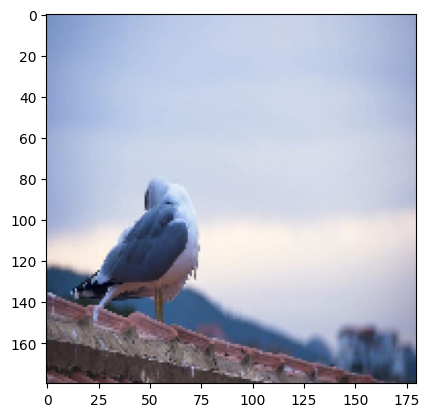

In [55]:

img = keras.utils.load_img("dataset/test/images/BT (31).jpg", target_size=image_size)

plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))

print(f"this image is {100 * (1 - score):.2f}% a drone and {100 * score:.2f}% a bird")